Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.55


In [32]:
project_folder=os.getcwd()
data_folder='trainDataset'
script_folder = os.path.join(os.getcwd(), "keras_train")
script_folder = project_folder # for now I keep the scripts in the main folder
os.makedirs(script_folder, exist_ok=True)

### Only Once - unzip the data

In [ ]:
data_folder2 = os.path.join(os.getcwd(), 'dataLH')
file_name='Training.zip'
zippedFile=os.path.join(data_folder2, file_name)

In [43]:
from zipfile import ZipFile
import numpy as np
import struct
from matplotlib import image
from matplotlib import pyplot

def unzipData(zippedFile):
    with ZipFile(zippedFile, 'r') as zz:
        zz.extractall()
        

In [44]:
file_name='Training.zip'
zippedFile=os.path.join(data_folder2, file_name)
unzipData(zippedFile)

file_name='Testing.zip'
zippedFile=os.path.join(data_folder2, file_name)
unzipData(zippedFile)

In [33]:
unzippedTrain=os.path.join(os.getcwd(),'Training')
unzippedTest=os.path.join(os.getcwd(),'Testing')
print(unzippedTrain)
print(os.listdir(unzippedTrain))


/mnt/azmnt/code/Users/Training
['4U', 'Background', 'EW', 'LH_new', 'LH_old', 'LH_veryold', 'LX', 'OS']


### Visualize Trainig Data

In [34]:
unzipped=unzippedTrain

/mnt/azmnt/code/Users/Training/4U


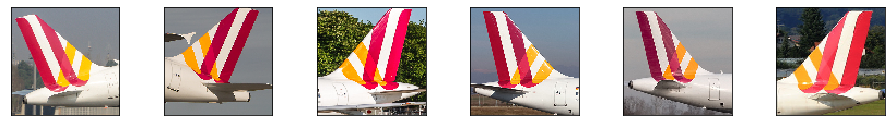

/mnt/azmnt/code/Users/Training/LH_new


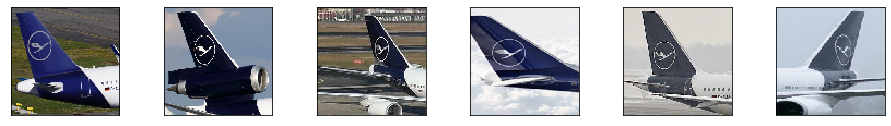

In [35]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
subfolders=os.listdir(unzipped)


fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 2),
        subplot_kw={'xticks': [], 'yticks': []})
i=0
for uf in subfolders[0:1]:
    folderPath=os.path.join(unzipped,uf)
    print(folderPath)
    for ff in os.listdir(folderPath)[1:7]:
        filePath=os.path.join(folderPath,ff)
        image = load_img(filePath, target_size=(100, 100))
        ax=axs[i]
        ax.imshow(image)
        i=i+1

plt.show()        


fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 2),
        subplot_kw={'xticks': [], 'yticks': []})
i=0
for uf in subfolders[3:4]:
    folderPath=os.path.join(unzipped,uf)
    print(folderPath)
    for ff in os.listdir(folderPath)[1:7]:
        filePath=os.path.join(folderPath,ff)
        image = load_img(filePath, target_size=(100, 100))
        ax=axs[i]
        ax.imshow(image)
        i=i+1

plt.show()        

#data=image.imread(filePath)/255


### Convert images to list of np.array

In [104]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import argparse
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle 
from keras.utils import np_utils

def image2data(unzipped='',target_size=(150,150), normalize=True, folder='train'):
    ncol=150
    nrow=150
    nchannels=3
    
    y=list()
    x=list()
    fileIndex=list()
    
    for uf in os.listdir(unzipped):
        folderPath=os.path.join(unzipped,uf)
        print(uf)
        for ff in os.listdir(folderPath):
            filePath=os.path.join(folderPath,ff)
        
            image = load_img(filePath, target_size=target_size)
            data=img_to_array(image)
            if normalize: data=data/255
            x=x+[data]        
            y=y+[uf]
            fileIndex=fileIndex+[filePath]
    x=np.array(x)
    y=np.array(y)

    ##################################### one hot encoding for the labels in needed in Keras
    print('')
    print('Encoding targets')
    
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_y)

    
    ############################################################################################
    if folder == 'train':
        print('')
        print('Splittint train and validation sets')
    
        x_train, x_val, y_train, y_val = train_test_split(x, dummy_y, test_size=0.2, random_state=42)
        allsets={'x_train':x_train,'x_val':x_val,'y_train':y_train,'y_val':y_val}
    else: 
        x_test=x
        y_test=y
        allsets={'x_test':x_test,'y_test':y_test}     
    
    print('')
    print('Writing files')
    
    outputFolder= folder+'Dataset'
    
    for n in allsets:
            filename= n+'.tsv'
            print(filename,allsets[n].shape)
            with open(os.path.join(outputFolder, filename),"wb") as f:
                 pickle.dump(allsets[n],f)
                    
    if folder =='train':   
        with open(os.path.join(outputFolder, "encoder"),"wb") as f:
             pickle.dump(encoder,f)
    


In [105]:
image2data(unzipped=unzippedTrain,folder='train')

4U
Background
EW
LH_new
LH_old
LH_veryold
LX
OS

Encoding targets

Splittint train and validation sets

Writing files
x_train.tsv (1025, 150, 150, 3)
x_val.tsv (257, 150, 150, 3)
y_train.tsv (1025, 8)
y_val.tsv (257, 8)


In [42]:
image2data(unzipped=unzippedTest,folder='test')

4U
Background
EW
LH_new
LH_old

Encoding targets

Writing files


In [106]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "y_train.tsv"),"rb") as f:
     y_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
with open(os.path.join('trainDataset', "y_val.tsv"),"rb") as f:
     y_val=pickle.load(f)
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)      
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)

### Preparation for the model

In [72]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [84]:
ntrain=len(x_train)
nval=len(x_val)
batch_size=32

In [74]:
print(x_train.shape)
print(y_train.shape)

(1025, 150, 150, 3)
(1025, 8)


In [75]:
model=models.Sequential()

model.add(layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(8,activation='sigmoid'))

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 64)        36928     
__________

In [77]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])


In [78]:
trainDataGen= ImageDataGenerator(
                    rescale=1.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2
                    )
valDataGen=ImageDataGenerator(rescale=1.)

In [107]:
trainGenerator=trainDataGen.flow(x_train,y_train,batch_size = batch_size)
valGenerator=valDataGen.flow(x_val,y_val,batch_size = batch_size)

In [108]:
y_val

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [109]:
history=model.fit_generator(trainGenerator,
                            steps_per_epoch = ntrain//batch_size,
                            epochs = 16,
                            validation_data = valGenerator,
                            validation_steps = nval//batch_size+1
                           )

Epoch 1/16
32/32 [==============================] - 10s 325ms/step - loss: 1.5233 - acc: 0.2969 - val_loss: 1.3063 - val_acc: 0.2812
Epoch 2/16
32/32 [==============================] - 10s 299ms/step - loss: 1.4230 - acc: 0.2864 - val_loss: 1.1395 - val_acc: 0.4062
Epoch 3/16
32/32 [==============================] - 10s 299ms/step - loss: 1.3476 - acc: 0.2913 - val_loss: 1.1343 - val_acc: 0.2812
Epoch 4/16
32/32 [==============================] - 10s 306ms/step - loss: 1.2363 - acc: 0.3578 - val_loss: 1.0631 - val_acc: 0.5938
Epoch 5/16
32/32 [==============================] - 10s 302ms/step - loss: 1.2197 - acc: 0.3988 - val_loss: 1.0404 - val_acc: 0.5312
Epoch 6/16
32/32 [==============================] - 10s 302ms/step - loss: 1.0763 - acc: 0.5494 - val_loss: 0.7986 - val_acc: 0.6875
Epoch 7/16
32/32 [==============================] - 10s 299ms/step - loss: 0.9779 - acc: 0.5787 - val_loss: 0.9193 - val_acc: 0.5625
Epoch 8/16
32/32 [==============================] - 10s 298ms/step - 

### Saving the model

In [367]:
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

### Visualize

In [372]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(len(acc))

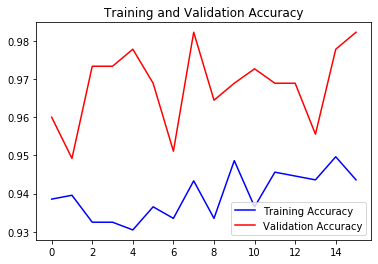

In [385]:
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend( loc="lower right")
plt.title('Training and Validation Accuracy')
plt.show()

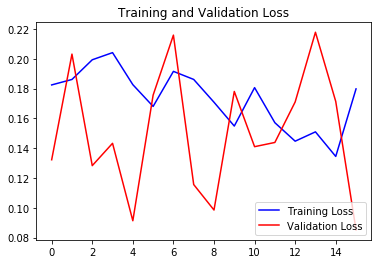

In [386]:
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend( loc="lower right")
plt.title('Training and Validation Loss')
plt.show()

## Test the model

###### We use the test set prepared before

In [512]:
predicted=model.predict(x_test)
pred=[]
for p in predicted:
   # pred.append((p//np.amax(p)).astype(int))
    pred.append(np.argmax(p))
labels = encoder.inverse_transform(np.array(pred))   


In [521]:
sep=np.repeat('/',len(labels))
labelsValid=np.core.defchararray.add(np.core.defchararray.add(labels,sep),y_test)

array(['4U / 4U', 'LH_veryold / 4U', '4U / 4U', '4U / 4U', '4U / 4U',
       'Background / Background', 'Background / Background',
       'Background / Background', 'EW / EW', 'LH_new / LH_new',
       'LH_new / LH_new', 'LH_new / LH_new'], dtype='<U23')

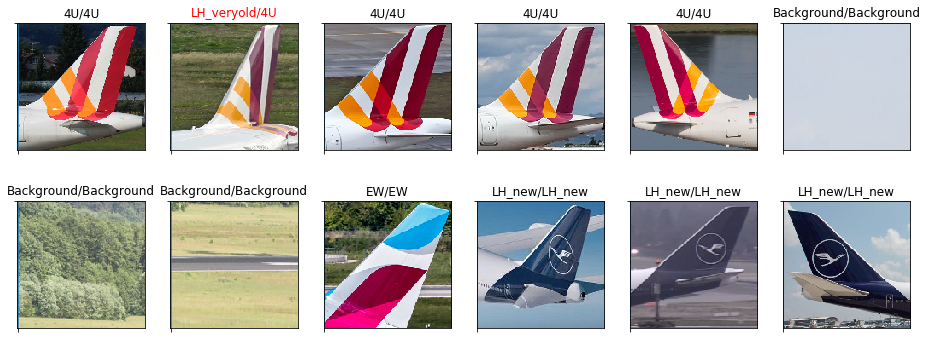

In [535]:

i=0
plt.figure(figsize = (16,6))

for p in range(len(predicted)):    
    imgData=x_test[p]
    
    plt.subplot(2, len(labels)//2, p+1)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(imgData, cmap=plt.cm.Greys)
    title_obj=plt.title(labelsValid[p], fontsize=12)
    if (labels[p]!=y_test[p]):
        plt.setp(title_obj, color='r')         #set the color of title to red

    
plt.show()

'/mnt/azmnt/code/Users'

### Create an estimator

An estimator object is used to submit the run. Azure Machine Learning has pre-configured estimators for common machine learning frameworks, as well as generic Estimator. Create SKLearn estimator for scikit-learn model, by specifying

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore (`ds.path('mnist').as_mount()`).

In [563]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('trainDataset').as_mount()
}

est = TensorFlow(source_directory=script_folder,
                 entry_script='train.py',
                 script_params=script_params,
                 compute_target=compute_target,
                 pip_packages=['keras', 'matplotlib','sklearn'],
                 use_gpu=False)

W0823 10:00:07.681360 139805705586432 _framework_base_estimator.py:238] framework_version is not specified, defaulting to version 1.13.


This is what the mounting point looks like:

### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [560]:
%%writefile $project_folder/.amlignore
data
sourceData
Training
Testing
trainDataset
testDataset
dataLH
model_keras.h5
model_weights.h5
model_wieghts.h5

Overwriting /mnt/azmnt/code/Users/.amlignore


In [564]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifier,ImageClassifier_1566554419_8b65daee,azureml.scriptrun,Starting,Link to Azure Portal,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run


In [565]:
from azureml.widgets import RunDetails
RunDetails(run).show()

A Jupyter Widget

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [ ]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [ ]:
print(run.get_metrics())

In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [ ]:
print(run.get_file_names())

Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [ ]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train multiple models on a remote cluster using the popular scikit-learn machine learning library
> * Review training details and register the best model

You are ready to deploy this registered model using the instructions in the next part of the tutorial series:

> [Tutorial 2 - Deploy models](img-classification-part2-deploy.ipynb)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)